# Model Inference
Infer from a cosmological model via MCMC samplers. 

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.5' # NOTE: jax preallocates GPU (default 75%)
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, config as jconfig, jit, vmap, grad, debug, tree
jconfig.update("jax_enable_x64", True)

from functools import partial
from getdist import plots
from numpyro import infer

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload
from montecosmo.mcbench import sample_and_save
from montecosmo.script import from_id, get_mcmc, get_init_mcmc

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# mlflow.set_experiment("infer")
# !jupyter nbconvert --to script ./src/montecosmo/tests/infer_model.ipynb/

%matplotlib inline
%load_ext autoreload
%autoreload 2
!hostname

feynmangpu04.cluster.local


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Config and fiduc

Running for a_obs=0.1


2025-02-19 19:47:40.694277: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


deconv
Running for a_obs=0.5
deconv
Running for a_obs=1.0
deconv


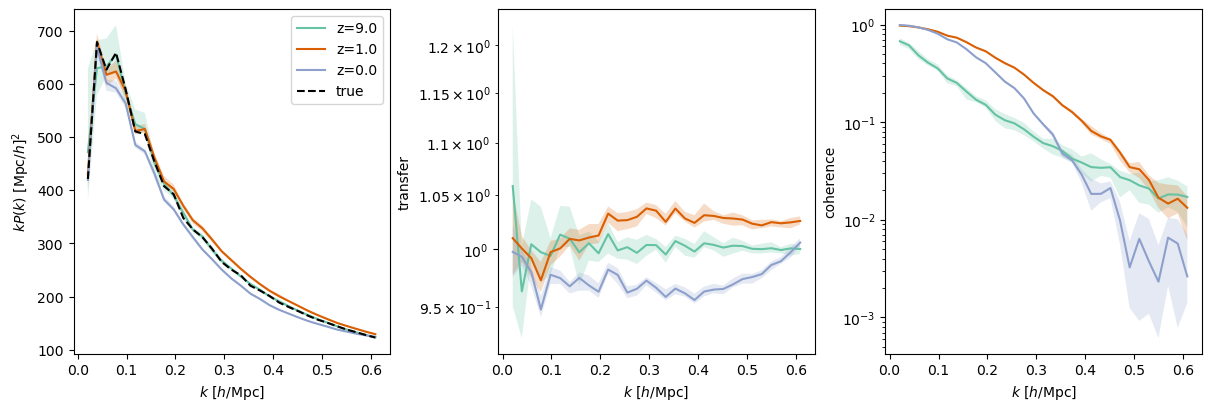

In [2]:
from montecosmo.model import FieldLevelModel, default_config
from montecosmo.plot import plot_pow, plot_powtranscoh, plot_coh, theme
from montecosmo.nbody import paint_kernel, rfftk
theme()
model = FieldLevelModel(**default_config)

a_obss = [0.1, 0.5, 1.]
# kpow0s = []
# kptcs = []
# kptc_obss = []

prob = 0.95
plt.figure(figsize=(12, 4), layout='constrained')
for i_a, a_obs in enumerate(a_obss):
    print(f"Running for a_obs={a_obs}")

    model.a_obs = a_obs
    model.mesh_shape = 3 * (128,)
    model.box_shape = 5 * np.array(model.mesh_shape)
    model.evolution = 'lpt'
    model.lpt_order = 2
    model.nbody_steps = 20

    model.loc_fid['b1'] = 1.
    truth = {'Omega_m': 0.31, 
            'sigma8': 0.81, 
            'b1': 1.,
            'b2':0., 
            'bs2':0., 
            'bn2': 0.}
    
    truth = model.predict(samples=truth, hide_base=False, hide_samp=False, frombase=True)
    delta_obs = truth['obs'] - 1
    # delta_obs = jnp.fft.rfftn(truth['obs'] - 1) / paint_kernel(rfftk(model.mesh_shape), order=2)
    # delta_obs = jnp.fft.irfftn(delta_obs)
    kaiser_post = jit(vmap(partial(model.kaiser_post, delta_obs=delta_obs, base=True)))(jr.split(jr.key(42), 16))

    mesh0 = jnp.fft.irfftn(truth['init_mesh'])
    kpow0 = model.spectrum(mesh0)
    # kpow0s.append(kpow0)

    kptc = vmap(lambda x: model.powtranscoh(mesh0, jnp.fft.irfftn(x['init_mesh'])))(kaiser_post)
    # kptcs.append(kptc)

    kptc_obs = model.powtranscoh(mesh0, delta_obs)
    # kptc_obss.append(kptc_obs)

    plot_powtranscoh(*jnp.median(jnp.stack(kptc), 1), label=f'z={1 / a_obs - 1}')
    plot_powtranscoh(*kptc, fill=prob)

    plt.subplot(131)
    if i_a == len(a_obss) - 1:
        plot_pow(*kpow0, 'k--', label='true')
        # plot_pow(*kptc_obs[:2], ':', c='grey', label='obs')
    plt.legend()

    # plt.subplot(133)
    # plot_coh(kptc_obs[0], kptc_obs[-1], ':', c='grey', label='obs')


# plt.savefig(f'kaiser_post_ev2lpt.svg')

Running for a_obs=0.1
Running for a_obs=0.5
Running for a_obs=1.0


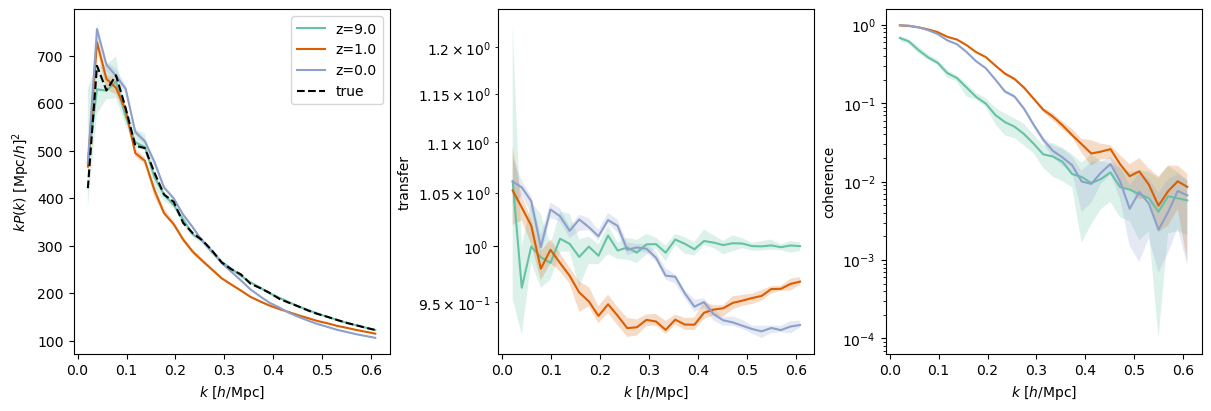

In [ ]:
from montecosmo.model import FieldLevelModel, default_config
from montecosmo.plot import plot_pow, plot_powtranscoh, plot_coh, theme
theme()
model = FieldLevelModel(**default_config)

a_obss = [0.1, 0.5, 1.]
# kpow0s = []
# kptcs = []
# kptc_obss = []

prob = 0.95
plt.figure(figsize=(12, 4), layout='constrained')
for i_a, a_obs in enumerate(a_obss):
    print(f"Running for a_obs={a_obs}")

    model.a_obs = a_obs
    model.mesh_shape = 3 * (128,)
    model.box_shape = 5 * np.array(model.mesh_shape)
    model.evolution = 'nbody'
    model.lpt_order = 1
    model.nbody_steps = 20

    model.loc_fid['b1'] = 1.
    truth = {'Omega_m': 0.31, 
            'sigma8': 0.81, 
            'b1': 1.,
            'b2':0., 
            'bs2':0., 
            'bn2': 0.}
    
    truth = model.predict(samples=truth, hide_base=False, hide_samp=False, frombase=True)
    delta_obs = truth['obs'] - 1
    kaiser_post = jit(vmap(partial(model.kaiser_post, delta_obs=delta_obs, base=True)))(jr.split(jr.key(42), 16))

    mesh0 = jnp.fft.irfftn(truth['init_mesh'])
    kpow0 = model.spectrum(mesh0)
    # kpow0s.append(kpow0)

    kptc = vmap(lambda x: model.powtranscoh(mesh0, jnp.fft.irfftn(x['init_mesh'])))(kaiser_post)
    # kptcs.append(kptc)

    kptc_obs = model.powtranscoh(mesh0, delta_obs)
    # kptc_obss.append(kptc_obs)

    plot_powtranscoh(*jnp.median(jnp.stack(kptc), 1), label=f'z={1 / a_obs - 1}')
    plot_powtranscoh(*kptc, fill=prob)

    plt.subplot(131)
    if i_a == len(a_obss) - 1:
        plot_pow(*kpow0, 'k--', label='true')
        # plot_pow(*kptc_obs[:2], ':', c='grey', label='obs')
    plt.legend()

    # plt.subplot(133)
    # plot_coh(kptc_obs[0], kptc_obs[-1], ':', c='grey', label='obs')


# plt.savefig(f'kaiser_post_evnbody.svg')

In [ ]:
from montecosmo.mcbench import Samples
params_ = Samples(truth, model.groups | model.groups_)[['cosmo_','init_']].data
params = model.reparam(params_)
params2_ = model.reparam(params, inv=True)
params2 = model.reparam(params2_)
mse_fn = lambda x,y: ((x-y)**2).mean()
tree.map(mse_fn,params2, params), tree.map(mse_fn, params2_, params_)

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

({'Omega_m': Array(0., dtype=float32),
  'init_mesh': Array(-7.440555e-14+3.259694e-12j, dtype=complex64),
  'sigma8': Array(0., dtype=float32)},
 {'Omega_m_': Array(0., dtype=float32),
  'init_mesh_': Array(6.7073295e-15, dtype=float32),
  'sigma8_': Array(5.585864e-15, dtype=float32)})

In [ ]:
meshes = []
for pc in [0,1,2,3]:
    dir = get_save_dir(**model.__dict__ | {'precond':pc})
    # mesh = jnp.fft.irfftn(pload(dir + "truth.p")['init_mesh'])
    mesh = pload(dir + "truth.p")['obs']
    meshes.append(mesh)

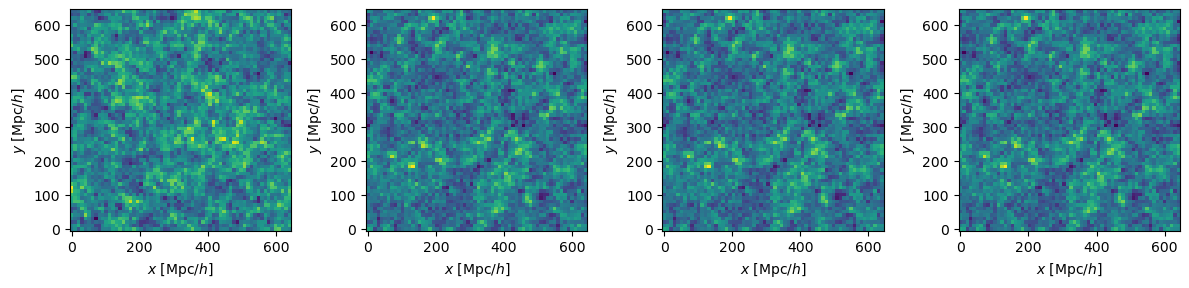

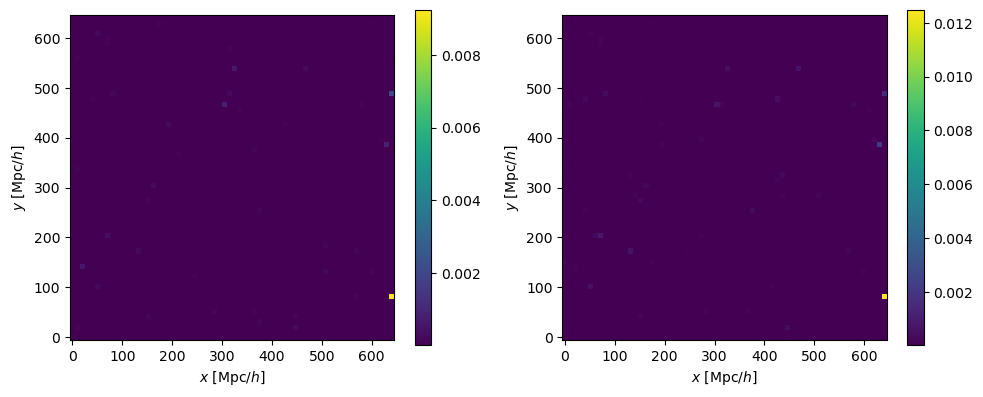

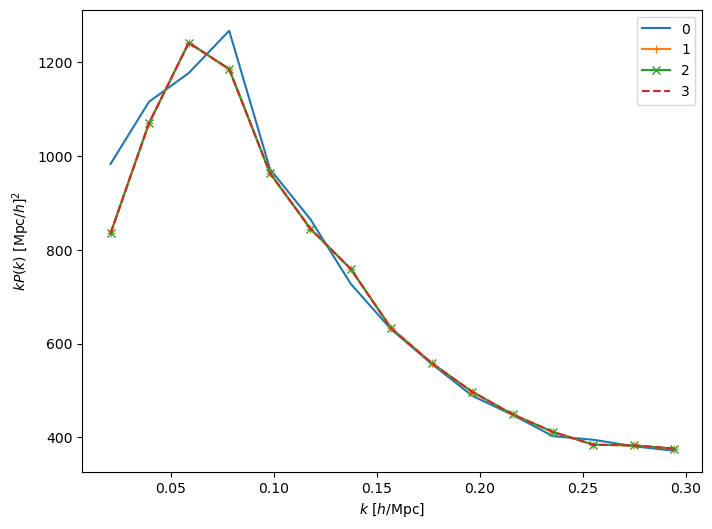

In [ ]:
from montecosmo.plot import plot_mesh, plot_pk, plot_bivar
plt.figure(figsize=(12, 6))
for i_plt, mesh in enumerate(meshes):
    plt.subplot(1,len(meshes),i_plt+1)
    plot_mesh(mesh, model.box_shape)
plt.tight_layout()

plt.figure(figsize=(10, 4))
# plot_bivar(relerr, 3)
relerr = lambda x,y: jnp.abs(x-y)/(jnp.abs(x)+jnp.abs(y))
plt.subplot(121)
plot_mesh(relerr(meshes[1], meshes[2]), model.box_shape)
plt.colorbar()
plt.subplot(122)
plot_mesh(relerr(meshes[1], meshes[3]), model.box_shape)
plt.colorbar()
plt.tight_layout()

plt.figure(figsize=(8, 6))
cs = ['', '-+', '-x', '--']
for i_plt, mesh in enumerate(meshes):
    kpk = model.spectrum(mesh)
    plot_pk(*kpk, cs[i_plt], label=f"{i_plt}")
plt.legend()
plt.show()